<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/PyTorch/Computer_Vision_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Computer Vision

### Importing Datasets

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

--2023-08-21 05:08:08--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2023-08-21 05:08:08 (59.9 MB/s) - ‘helper_functions.py’ saved [10160/10160]



In [3]:
import torch
import numpy as np
import pandas as pd
from torch import nn

In [4]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
print(torch.__version__)

2.0.1+cu118


### Getting a dataset

In [6]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
    )
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10359338.60it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174738.00it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3213832.87it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5920558.54it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
len(train_data),len(test_data)

(60000, 10000)

In [8]:
image,label = train_data[0]

In [9]:
class_names = train_data.classes

In [10]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
image.shape

torch.Size([1, 28, 28])

### Visualizing Dataset

In [12]:
def visualize_dataset(dataset):
  torch.manual_seed(42)
  fig = plt.figure(figsize=(9,9))
  rows,cols = 4,4
  for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    image,label = dataset[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(image.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)


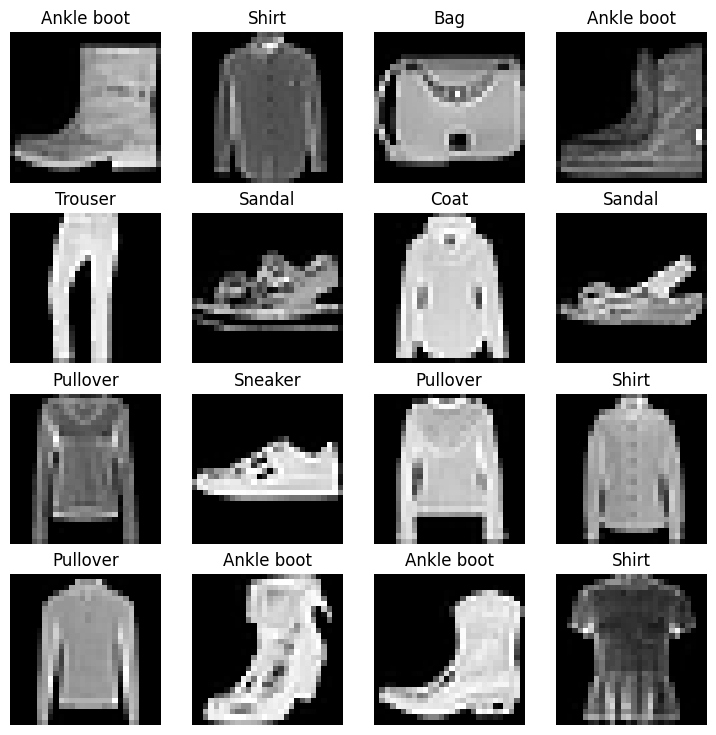

In [13]:
visualize_dataset(train_data)

### Preparing DataLoader

In [14]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=False)

### BaseLine Model:0

In [15]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_shape)

    )
  def forward(self,x):
    return self.layer_stack(x)


In [16]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(28*28,10,256)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=256, bias=True)
  )
)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),lr=0.001)


In [18]:
from helper_functions import accuracy_fn

### Timing Experiments

In [19]:
from timeit import default_timer as timer
def print_train_time(start,end,device):
  total = end-start
  print("Train time on",device,":",total," seconds")
  return total

### Training and Testing Loop

In [20]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()
epochs = 3
for epoch in tqdm(range(1,epochs+1)):
  print(f"Epoch: {epoch}")
  ###Training
  train_loss = 0
  #Loop to Loop through the training batches
  for batch,(X,y) in enumerate(train_dataloader):
    model_0.train()
    # Forward Pass
    y_pred = model_0(X)
    loss = loss_fn(y_pred,y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%400==0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss/=len(train_dataloader)
  #Testing
  test_loss,test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for batch,(X_test,y_test) in enumerate(test_dataloader):
      test_pred = model_0(X_test)
      test_loss+=loss_fn(test_pred,y_test)
      test_acc+=accuracy_fn(y_test,test_pred.argmax(dim=1))

    test_loss/=len(test_dataloader)
    test_acc/=len(test_dataloader)
  print(f"Train Loss:{train_loss:.4f}|Test Loss:{test_loss:.4f}|Test Accuracy:{test_acc:.4f}")

train_time_end_on_cpu = timer()
print(print_train_time(train_time_start_on_cpu,train_time_end_on_cpu,device=str(next(model_0.parameters()).device)))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.7538|Test Loss:0.5274|Test Accuracy:81.5296
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.4760|Test Loss:0.4883|Test Accuracy:82.4381
Epoch: 3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.4474|Test Loss:0.4786|Test Accuracy:83.1370
Train time on cpu : 52.69214805100002  seconds
52.69214805100002


### Make Predictions and get Model_0 Results

In [21]:
torch.manual_seed(42)
def eval_model(model,data_loader,loss_fn,accuracy_fn,device):
  loss,acc=0,0
  model.eval()
  with torch.inference_mode():
    for batch,(X,y) in enumerate(data_loader):
      X=X.to(device)
      y=y.to(device)
      y_pred = model(X)
      loss+=loss_fn(y_pred,y)
      acc+=accuracy_fn(y,y_pred.argmax(dim=1))

    loss/=len(data_loader)
    acc/=len(data_loader)
  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc
          }


In [22]:
model_0_results = eval_model(model_0,test_dataloader,loss_fn,accuracy_fn,device="cpu")

### Running on GPU

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Functionizing Loop

In [24]:
from tqdm.auto import tqdm
def train_test_loop(epochs,model,train_dataloader,test_dataloader,device,accuracy_fn,loss_fn,optimizer):
  torch.manual_seed(42)
  train_time_start_on_cpu = timer()
  epochs = epochs
  for epoch in tqdm(range(1,epochs+1)):
    print(f"Epoch: {epoch}")
    ###Training
    train_loss = 0
    train_acc = 0
    #Loop to Loop through the training batches
    for batch,(X,y) in enumerate(train_dataloader):
      X=X.to(device)
      y=y.to(device)
      model.train()
      # Forward Pass
      y_pred = model(X)
      loss = loss_fn(y_pred,y)
      train_loss+=loss
      train_acc+= accuracy_fn(y,y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch%400==0:
        print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)
    #Testing
    test_loss,test_acc = 0,0
    model.eval()
    with torch.inference_mode():
      for batch,(X_test,y_test) in enumerate(test_dataloader):
        X_test=X_test.to(device)
        y_test=y_test.to(device)
        test_pred = model(X_test)
        test_loss+=loss_fn(test_pred,y_test)
        test_acc+=accuracy_fn(y_test,test_pred.argmax(dim=1))

      test_loss/=len(test_dataloader)
      test_acc/=len(test_dataloader)
    print(f"Train Loss:{train_loss:.4f}|Train Accuracy:{train_acc:.4f}|Test Loss:{test_loss:.4f}|Test Accuracy:{test_acc:.4f}")

  train_time_end_on_cpu = timer()
  print(print_train_time(train_time_start_on_cpu,train_time_end_on_cpu,device=str(next(model.parameters()).device)))

## Model 1: Model with Non-Linearity

In [25]:
class FashionMNISTV1(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,X):
    return self.layer_stack(X)

In [26]:
torch.manual_seed(42)
model_1 = FashionMNISTV1(28*28,10,128).to(device)
model_1

FashionMNISTV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=0.0001)

In [28]:
train_test_loop(3,model_1,train_dataloader,test_dataloader,device,accuracy_fn,loss_fn,optimizer)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.7752|Train Accuracy:74.0200|Test Loss:0.5432|Test Accuracy:81.0503
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.4805|Train Accuracy:83.3017|Test Loss:0.4821|Test Accuracy:82.8674
Epoch: 3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.4359|Train Accuracy:84.7600|Test Loss:0.4511|Test Accuracy:84.0256
Train time on cuda:0 : 37.01492420699998  seconds
37.01492420699998


In [29]:
model_1_results = eval_model(model_1,test_dataloader,loss_fn,accuracy_fn,device)
model_1_results

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.45107558369636536,
 'model_acc': 84.02555910543131}

## Model 2: Convulutional Neural Network

In [53]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self,input_shape,output_shape,hidden_units=8):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,out_channels=hidden_units,
            kernel_size=3,stride=1,padding=1
            ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,out_channels=hidden_units,
            kernel_size=3,stride=1,padding=1
            ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,out_channels=hidden_units,
            kernel_size=3,stride=1,padding=1
            ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,out_channels=hidden_units,
            kernel_size=3,stride=1,padding=1
            ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,out_features=output_shape),
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [75]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(1,10,hidden_units=10).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [76]:
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [77]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [78]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Loss Function and Optimizer

In [79]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),lr=0.001)

In [80]:
train_test_loop(6,model_2,train_dataloader,test_dataloader,device,accuracy_fn,loss_fn,optimizer)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.5370|Train Accuracy:80.4200|Test Loss:0.3941|Test Accuracy:85.5831
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.3592|Train Accuracy:87.0133|Test Loss:0.3818|Test Accuracy:86.1621
Epoch: 3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.3249|Train Accuracy:88.4333|Test Loss:0.3383|Test Accuracy:87.5100
Epoch: 4
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train Loss:0.3046|Train Accuracy:88.9483|Test Loss:0.3217|Test Accuracy:88.2089
Epoch: 5
Looked at 0/60000 samples
Looked at 12800/60000 sam

In [81]:
model_2_results = eval_model(model_2,test_dataloader,loss_fn,accuracy_fn,device)

In [82]:
import pandas as pd
results = pd.DataFrame([model_0_results,model_1_results,model_2_results])

In [83]:
results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.478636,83.136981
1,FashionMNISTV1,0.451076,84.025559
2,FashionMNISTModelV2,0.308467,89.047524


Text(0, 0.5, 'model')

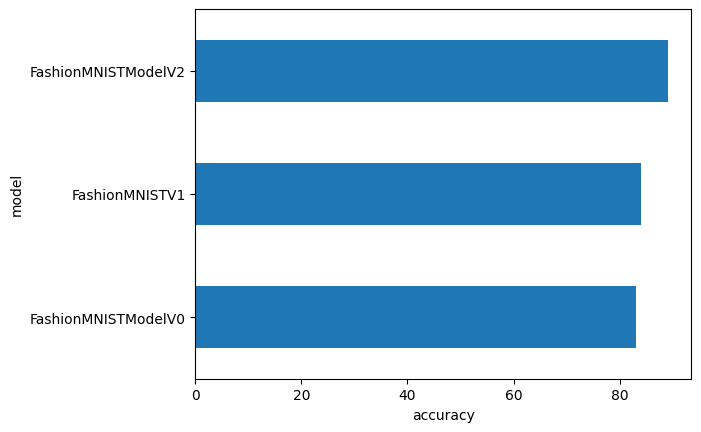

In [85]:
results.set_index('model_name')['model_acc'].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("model")

## Predicting Random Test Samples

In [95]:
def make_predictions(model,data,device):
  pred_probs=[]
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)


In [101]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample,label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [102]:
pred_probs = make_predictions(model_2,test_samples,device)

In [103]:
pred_classes = pred_probs.argmax(dim=1)

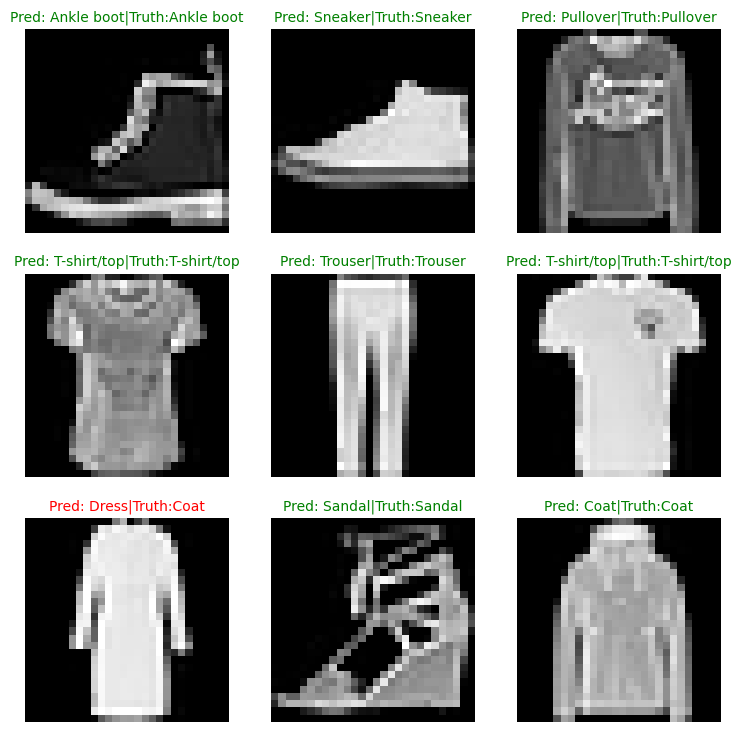

In [105]:
plt.figure(figsize=(9,9))
rows,cols=3,3
for i,sample in enumerate(test_samples):
  plt.subplot(rows,cols,i+1)
  plt.imshow(sample.squeeze(),cmap="gray")
  pred_label = class_names[pred_classes[i]]
  true_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label}|Truth:{true_label}"
  if pred_label==true_label:
    plt.title(title_text,fontsize=10,c="g")
  else:
    plt.title(title_text,fontsize=10,c="r")
  plt.axis(False)

### Plotting Confusion Matrix

In [110]:
import mlxtend
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for batch,(X,y) in tqdm(enumerate(test_dataloader),desc="Making Predictions"):
    X,y = X.to(device),y.to(device)
    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

Making Predictions: 0it [00:00, ?it/s]

In [111]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 10.1 MB/s eta 0:00:00


In [114]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(num_classes=len(class_names),task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,target=test_data.targets)

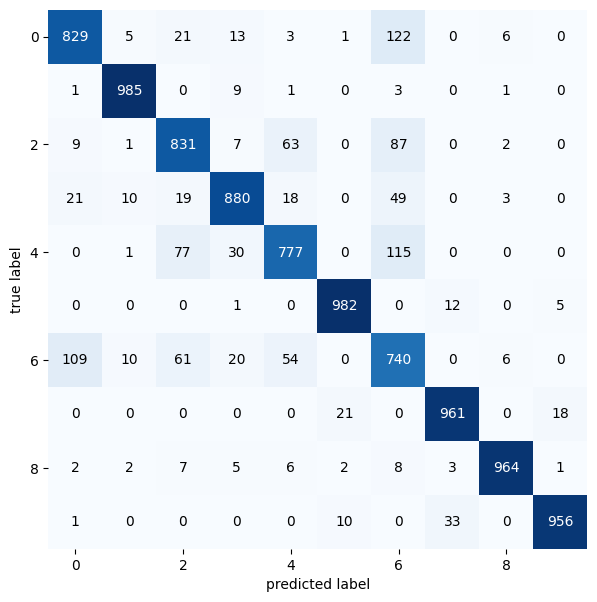

In [115]:
fig,ax = plot_confusion_matrix(confmat_tensor.numpy(),class_names,figsize=(10,7))